In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tqdm import tqdm, trange

# KMeans

In [ ]:
class KMeans:
    def __init__(self, X, k=2, mahalanobis=False):
        self.k = k
        self.centroids = []
        self.clusters = [[] for c in range(self.k)]
        self.X = X
        if mahalanobis == True:
            self.covariance = np.cov(self.X, rowvar=False)
            self.matrix = np.linalg.inv(self.covariance)
        else:
            self.matrix = np.eye(2)

    def _calculate_distance(self, x, y):
        return np.sqrt((x - y).T.dot(self.matrix).dot(x - y))

    def _nearest_centroid(self, x, centroids):
        closest_i = 0
        closest_dist = 10000
        for i, centroid in enumerate(centroids):
            distance = self._calculate_distance(x, centroid)
            if distance < closest_dist:
                closest_i = i
                closest_dist = distance
        return closest_i

    def _create_clusters(self, centroids, X):
        n_samples = np.shape(X)[0]
        for x_i, x in enumerate(X):
            centroid_i = self._nearest_centroid(x, centroids)
            self.clusters[centroid_i].append(x_i)

    def _calculate_centroids(self, clusters, X):
        centroids = np.zeros((self.k, np.shape(X)[1]))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
        self.centroids = centroids
        return centroids

    def _get_labels(self, clusters, X):
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for x_i in cluster:
                y_pred[x_i] = cluster_i
        return y_pred

    def fit_predict(self):
        centroids = pd.DataFrame(self.X).sample(self.k).to_numpy()

        for iteration in range(100):
            self._create_clusters(centroids, self.X)
            prev_centroids = centroids
            centroids = self._calculate_centroids(self.clusters, self.X)
            diff = centroids - prev_centroids
            if not diff.any():
                break

        return self._get_labels(self.clusters, self.X)

In [ ]:
kmean_df = pd.read_csv("quake.csv", header=None)
X_km = kmean_df
scaler = MinMaxScaler()
X_km = pd.DataFrame(scaler.fit_transform(X_km))
X = X_km.to_numpy()

In [8]:
db_euclidean_list = []
db_mahalanobis_list = []
kmeans = []
k_list = []
for k in trange(4, 21,desc='1st loop'):
    intra_db_euclidean = []
    intra_db_mahalanobis = []
    for i in range(100):
        try:
            kmeans_euclidean = KMeans(X=X, k=k, mahalanobis=False)
            db_euclidean = davies_bouldin_score(X, kmeans_euclidean.fit_predict())
            intra_db_euclidean.append(db_euclidean)
            
            kmeans_mahalanobis = KMeans(X=X, k=k, mahalanobis=True)
            db_mahalanobis = davies_bouldin_score(X, kmeans_mahalanobis.fit_predict())
            intra_db_mahalanobis.append(db_mahalanobis)

        except:
            continue
    db_euclidean_list.append(np.median(intra_db_euclidean))
    db_mahalanobis_list.append(np.median(intra_db_mahalanobis))

1st loop: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [04:45<00:00, 16.82s/it]


In [35]:
kmeans_euclidean = KMeans(X=X, k=11)
labels = kmeans_euclidean.fit_predict()
X_km["labels_euclidean"] = labels.astype(int)

In [33]:
kmeans_mahalanobis = KMeans(X=X, k=13, mahalanobis=True)
labels = kmeans_mahalanobis.fit_predict()
X_km["labels_mahalanobis"] = labels.astype(int)

## PLOT

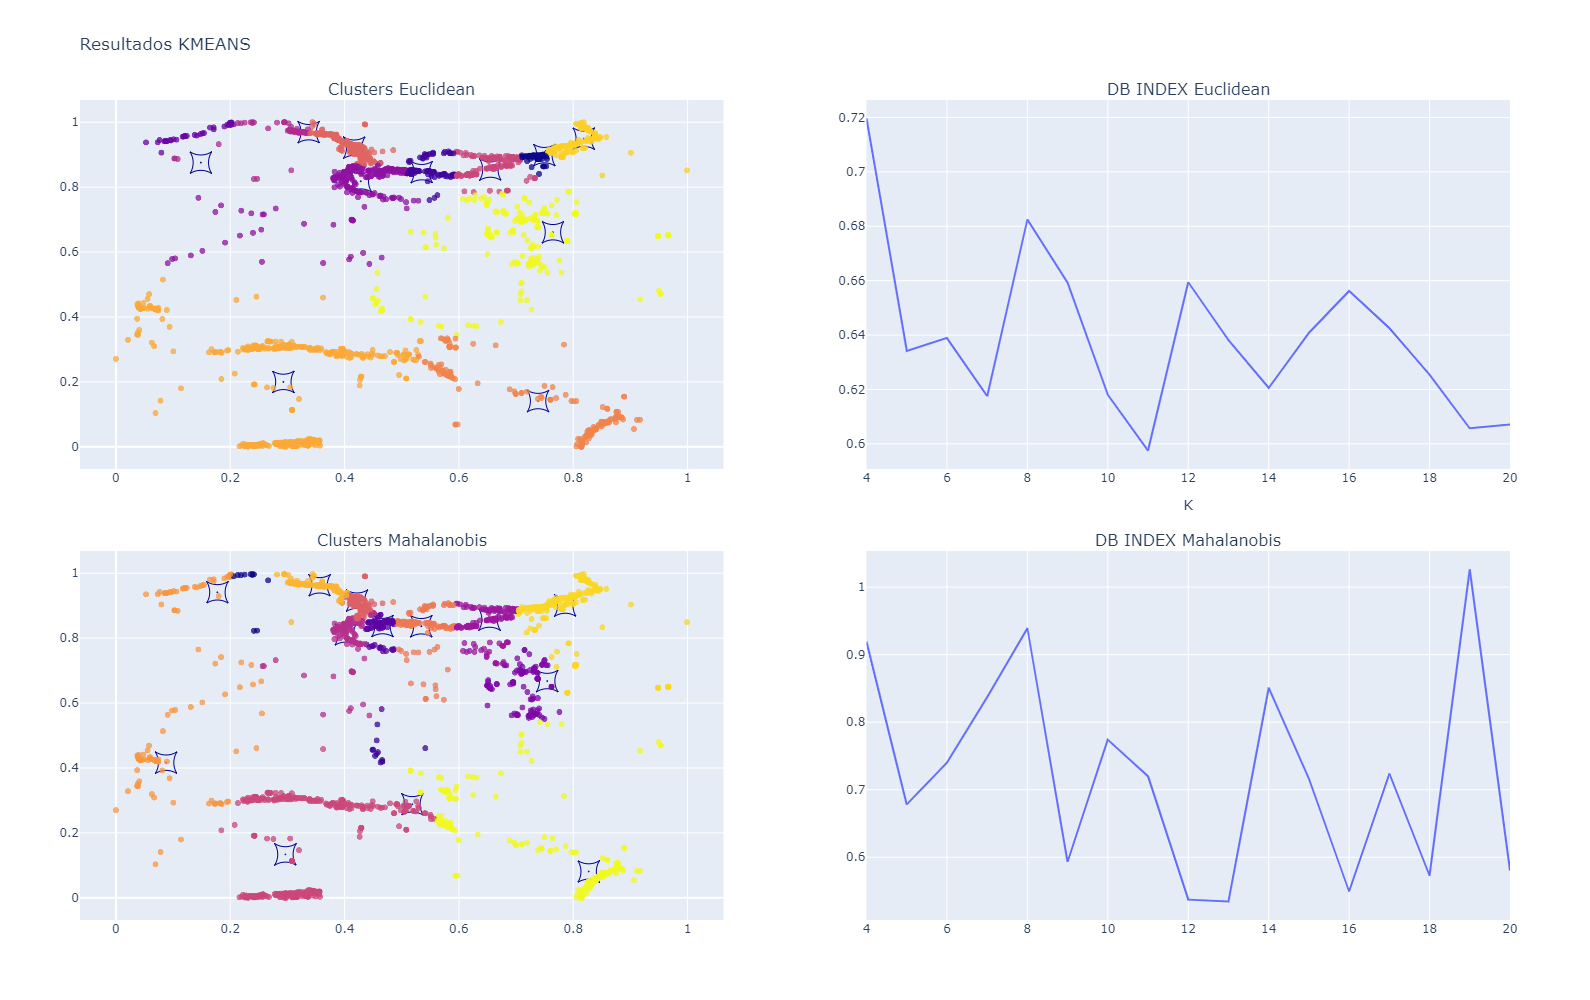

In [39]:
fig = None
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=[
        "Clusters Euclidean",
        "DB INDEX Euclidean",
        "Clusters Mahalanobis",
        "DB INDEX Mahalanobis",
        
    ],
    vertical_spacing=0.1
)

data_11 = px.scatter(X_km, x= 0, y= 1, color="labels_euclidean", opacity=0.75).data[0]
data_12 = px.line(x=list(range(4, 21)), y=db_euclidean_list).data[0]

fig.add_trace(data_11, row=1, col=1)
fig.add_trace(data_12, row=1, col=2)

fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(kmeans_euclidean.centroids)[0],
        y=pd.DataFrame(kmeans_euclidean.centroids)[1],
        mode="markers",
        marker=dict(size=20, color="darkblue", symbol="321"),
    ),
    row=1,
    col=1,
)


data_21 = px.scatter(X_km, x=0, y=1, color="labels_mahalanobis", opacity=0.75).data[0]
data_22 = px.line(x=list(range(4, 21)), y=db_mahalanobis_list).data[0]

fig.add_trace(data_21, row=2, col=1)
fig.add_trace(data_22, row=2, col=2)

fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(kmeans_mahalanobis.centroids)[0],
        y=pd.DataFrame(kmeans_mahalanobis.centroids)[1],
        mode="markers",
        marker=dict(size=20, color="darkblue", symbol="321"),
    ),
    row=2,
    col=1,
)


fig.update_xaxes(title_text="K", row=1, col=2)
fig.update_layout(
    showlegend=False,
    title_text=f"Resultados KMEANS",
    coloraxis_showscale=False,
    width=1400,
    autosize=False,
    height=1000,
)

# PCA

In [40]:
class PCA:
    def __init__(self):
        """
        Inicializando os autovalores e autovetores como atributos para
        pegar seus valores depois
        """
        self.eigenvalues = []
        self.eigenvectors = []

    def fit_transform(self, X, n_components):

        """
        1 - Calcula-se a matriz de covariância
        2 - Calcula-se os autovalores e os autovetores
        3 - Ordena-se os autovalores
        4 - Calcula-se a variância explicada total e a fração para cada componente

        """

        self.covariance_matrix = np.cov(X.T)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.covariance_matrix)
        self.idx = self.eigenvalues.argsort()[::-1]
        self.explained_variance_ratio_ = self.eigenvalues / np.sum(self.eigenvalues)
        self.eigenvalues = self.eigenvalues[self.idx][:n_components]
        self.eigenvectors = np.atleast_1d(self.eigenvectors[:, self.idx])[
            :, :n_components
        ]
        X_transformed = X.dot(self.eigenvectors)

        return X_transformed

In [41]:
pca_df = pd.read_csv("penguins.csv", header=None)
pca = PCA()

In [42]:
X_pca = pca_df.iloc[:, :-1]
X_scaled_pca = (pca_df.iloc[:, :-1] - pca_df.iloc[:, :-1].mean(axis=0)) / pca_df.iloc[
    :, :-1
].std(axis=0)
X_scaled_pca["classes"] = pca_df.iloc[:, -1]

In [43]:
X_reduced = pca.fit_transform(X_scaled_pca.iloc[:, :-1], 2)
X_reduced = pd.DataFrame(X_reduced)
X_reduced["classes"] = pca_df.iloc[:, -1]

In [44]:
pca.explained_variance_ratio_

array([0.68633893, 0.19452929, 0.09216063, 0.02697115])

## PLOT

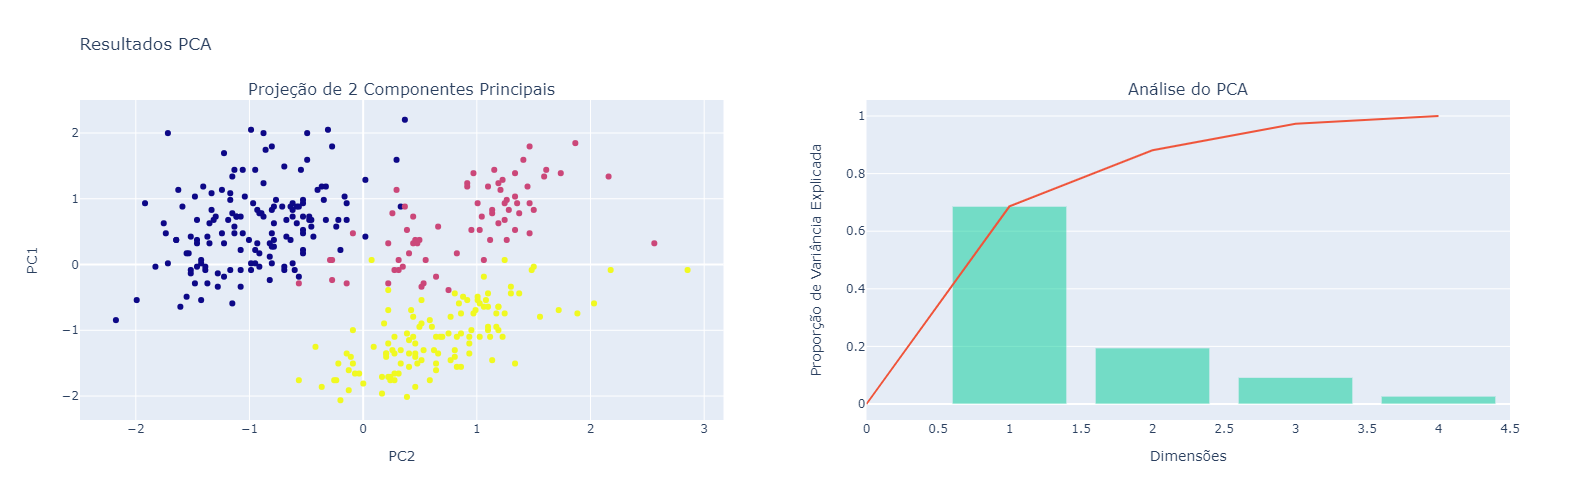

In [45]:
fig = None
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=[
        f"Projeção de 2 Componentes Principais",
        f"Análise do PCA",
    ],
)
data_1 = px.scatter(data_frame=X_scaled_pca, x=0, y=1, color="classes").data[0]
fig.add_trace(data_1, row=1, col=1)
fig.add_trace(
    go.Scatter(
        x=list(range(5)), y=[0, *np.cumsum(pca.explained_variance_ratio_)], mode="lines"
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Bar(x=list(range(1, 5)), y=pca.explained_variance_ratio_, opacity=0.5),
    row=1,
    col=2,
)
fig.update_xaxes(title_text="PC2", row=1, col=1)
fig.update_xaxes(title_text="Dimensões", row=1, col=2)
fig.update_yaxes(title_text="PC1", row=1, col=1)
fig.update_yaxes(title_text="Proporção de Variância Explicada", row=1, col=2)
fig.update_layout(
    showlegend=False,
    title_text=f"Resultados PCA",
    coloraxis_showscale=False,
    width=1200,
    autosize=False,
    height=500,
)